# Building metacells with a simple k-means

An example of building *metacells* using the k-means clustering. 
 

## Imports

In [11]:
import numpy as np
import pandas as pd
import scanpy as sc


import SEACells
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.cluster import KMeans

# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

In [12]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('../../Py/') # make a MC_metrics.py script to stote metric functions
import mc_QC

## Parameter
Requested graining level

In [13]:
## Parameters
I = 4
proj_name = ["cell_lines", "3k_pbmc"][1]

annotation_label = {'cell_lines':'cell_line',
                   '3k_pbmc':'louvain'}[proj_name]

gamma = [10, 20, 50, 75, 100][I] # the requested graing level


MC_tool = "Kmeans"

## Load data

In [14]:
# Load data pre-filtered data

data_folder = os.path.join("../../data/", proj_name)
ad = sc.read(os.path.join(data_folder, "anndata_filtered.h5ad"))

## Data processing 
In contrast to [Metacell-2](), SEACells build metacells based on processed data and takes as an input dimensionally reduced data (i.e., PCA for scRNA-seq data). Thus, we first compute PCA for our data usign the same set of genes used in the main [tutorial]()

In [15]:
# Save count as a separate layer
ad.layers['counts'] = ad.X

# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.layers['counts'])
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [16]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1000)



In [17]:
# Compute principal components - 
# Here we use 10 components to be consistent with out main tutorial, but fill free to explore other number of principal components to use 

n_comp    = 10
sc.tl.pca(ad, n_comps=n_comp, use_highly_variable=True)

# Compute UMAP for visualization 
sc.pp.neighbors(ad, n_neighbors=10, n_pcs=n_comp)
sc.tl.umap(ad)

In [18]:
hvg = pd.DataFrame(ad.var_names[ad.var['highly_variable']].to_list(), columns=['HVG'])
hvg.to_csv(os.path.join(data_folder, "hvg.csv"))

pca = pd.DataFrame(ad.obsm['X_pca'])
pca.to_csv(os.path.join(data_folder, "pca.csv"))

## Computing metacells 

In [9]:
## User defined parameters
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data
    
n_iter = 20

In [10]:
np.array(ad.obsm['X_pca'])

In [11]:
# The number of SEACells is computed as a ratio between the number of single cells and the desired graining level
n_SEACells = int(ad.shape[0]/gamma) 

#random.seed(12345)
kmeans = KMeans(n_clusters=n_SEACells, random_state=0).fit(np.array(ad.obsm['X_pca']))
membership = kmeans.labels_+1

In [12]:
ad.obs['membership'] = membership
ad.obs['SEACell'] = membership
ad.obs

In [13]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='membership', summarize_layer='raw')


In [14]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

In [15]:
## Save single-cell metadata (i.e., `ad.obs` dataframe) in the seacell adata object
SEACell_ad.uns = ad.uns.copy()
SEACell_ad.uns['sc.obs'] = ad.obs.copy()

SEACell_ad.var['feature_gene'] = ad.var['highly_variable'].astype(int)
SEACell_ad.obs['membership'] =  [int(i) for i in SEACell_ad.obs.index]
SEACell_ad.obs['gamma'] = gamma
SEACell_ad.obs['gamma_obtained'] = round(ad.shape[0]/SEACell_ad.shape[0])
SEACell_ad.obs['MC_tool'] = MC_tool


SEACell_ad.obs

In [16]:
SEACell_ad.uns['sc.obs']

### Metacell quality metrics 

In [254]:
mc_size_dist = ad.obs.membership.value_counts()
mc_size = pd.DataFrame(mc_size_dist).rename(columns={'membership':'size'})
mc_size['membership'] = mc_size.index

In [255]:
SEACell_ad.obs.membership.min()

1

In [256]:
SEACell_ad.obs = pd.merge(SEACell_ad.obs, mc_size, on=['membership'])

SEACell_ad.obs

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,membership,gamma,gamma_obtained,MC_tool,size
0,20,100,101,Kmeans,101
1,23,100,101,Kmeans,141
2,2,100,101,Kmeans,177
3,17,100,101,Kmeans,101
4,13,100,101,Kmeans,46
5,10,100,101,Kmeans,158
6,16,100,101,Kmeans,24
7,22,100,101,Kmeans,134
8,8,100,101,Kmeans,187
9,14,100,101,Kmeans,207


In [257]:
import importlib
importlib.reload(mc_QC)

MC_purity = mc_QC.purity(ad, annotation_label, MC_label = 'membership')
print(MC_purity)
MC_purity.index = SEACell_ad.obs.index
print(MC_purity)


SEACell_ad.obs = SEACell_ad.obs.join(MC_purity) #pd.merge(metacells.obs, MC_purity, left_index=True, right_index=True)


                      louvain  louvain_purity
membership                                   
1                 CD8 T cells        0.954545
2                 CD4 T cells        0.932203
3             CD14+ Monocytes        1.000000
4                     B cells        0.989362
5             Dendritic cells        0.531915
6                    NK cells        0.957447
7             CD14+ Monocytes        0.913978
8                 CD4 T cells        0.983957
9           FCGR3A+ Monocytes        0.889706
10                CD4 T cells        0.974684
11                CD8 T cells        0.814159
12             Megakaryocytes        1.000000
13                   NK cells        1.000000
14                CD4 T cells        0.980676
15            CD14+ Monocytes        1.000000
16                CD8 T cells        0.541667
17            CD14+ Monocytes        0.811881
18                CD4 T cells        0.973684
19                    B cells        1.000000
20                CD4 T cells     

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [258]:
SEACell_ad.obs = SEACell_ad.obs.iloc[:,:7]
SEACell_ad.obs
#n_comp

,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity
0,20,100,101,Kmeans,101,CD8 T cells,0.954545
1,23,100,101,Kmeans,141,CD4 T cells,0.932203
2,2,100,101,Kmeans,177,CD14+ Monocytes,1.000000
3,17,100,101,Kmeans,101,B cells,0.989362
4,13,100,101,Kmeans,46,Dendritic cells,0.531915
5,10,100,101,Kmeans,158,NK cells,0.957447
6,16,100,101,Kmeans,24,CD14+ Monocytes,0.913978
7,22,100,101,Kmeans,134,CD4 T cells,0.983957
8,8,100,101,Kmeans,187,FCGR3A+ Monocytes,0.889706
9,14,100,101,Kmeans,207,CD4 T cells,0.974684


In [259]:
SEACell_ad.obs['size'].value_counts()


46     3
101    2
47     2
136    1
53     1
88     1
112    1
107    1
93     1
50     1
94     1
228    1
141    1
113    1
90     1
207    1
187    1
134    1
24     1
158    1
177    1
12     1
Name: size, dtype: int64

In [260]:
import importlib
importlib.reload(mc_QC)
MC_label = 'membership'

compactness_PCA = mc_QC.compactness(ad, 'X_pca', MC_label = MC_label, DO_DC = False, name = 'Compactness_PCA', n_comp=n_comp)['Compactness_PCA']
compactness_DC  = mc_QC.compactness(ad, 'X_pca', MC_label = MC_label, DO_DC = True, name = 'Compactness_DC', n_comp=n_comp)['Compactness_DC']

SEACell_ad.obs = SEACell_ad.obs.join(compactness_PCA, on = MC_label)
SEACell_ad.obs = SEACell_ad.obs.join(compactness_DC, on = MC_label)

separation_PCA = mc_QC.separation(ad, 'X_pca', MC_label = MC_label, DO_DC = False, name = 'Separation_PCA', n_comp=n_comp)['Separation_PCA']
separation_DC  = mc_QC.separation(ad, 'X_pca', MC_label = MC_label, DO_DC = True, name = 'Separation_DC', n_comp=n_comp)['Separation_DC']

SEACell_ad.obs = SEACell_ad.obs.join(separation_PCA, on = MC_label)
SEACell_ad.obs = SEACell_ad.obs.join(separation_DC, on = MC_label)

SEACell_ad.obs


Determing nearest neighbor graph...


/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Determing nearest neighbor graph...


/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC
0,20,100,101,Kmeans,101,CD8 T cells,0.954545,0.247014,0.191804,1.243079,1.221194
1,23,100,101,Kmeans,141,CD4 T cells,0.932203,0.184963,0.460954,1.263424,0.921682
2,2,100,101,Kmeans,177,CD14+ Monocytes,1.000000,0.146080,0.059344,1.123368,0.313714
3,17,100,101,Kmeans,101,B cells,0.989362,0.225833,0.142595,2.048092,1.280357
4,13,100,101,Kmeans,46,Dendritic cells,0.531915,0.318305,0.005605,1.407537,0.419826
5,10,100,101,Kmeans,158,NK cells,0.957447,0.110991,0.002081,1.010509,0.039028
6,16,100,101,Kmeans,24,CD14+ Monocytes,0.913978,0.377290,0.420256,2.539777,0.826368
7,22,100,101,Kmeans,134,CD4 T cells,0.983957,0.164670,0.046350,1.248589,0.013391
8,8,100,101,Kmeans,187,FCGR3A+ Monocytes,0.889706,0.129208,0.006956,1.199680,0.039028
9,14,100,101,Kmeans,207,CD4 T cells,0.974684,0.126688,0.004756,1.010509,0.040099


In [261]:
# compute extra PC to evaluate performance of compactness and separation outside the n_comp used for MC construction
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)
ad.obsm['X_pca'].shape

(2638, 50)

### Compute *compactness* for a range of latent space components 

In [262]:
QC_compactness = pd.DataFrame()

# Compactness

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    
    compactness_PCA_i = mc_QC.compactness(ad, 'X_pca', n_comp = n_comp_i, DO_DC = False, MC_label = MC_label)
    compactness_DC_i  = mc_QC.compactness(ad, 'X_pca', n_comp = n_comp_i, DO_DC = True, MC_label = MC_label)
    
    QC_compactness = pd.concat([QC_compactness, compactness_PCA_i, compactness_DC_i], ignore_index=True)
QC_compactness


2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,compactness,low_dim_embedding,n_comp,membership
0,0.254590,X_pca,2,1
1,0.108783,X_pca,2,2
2,0.253928,X_pca,2,3
3,0.128085,X_pca,2,4
4,0.293546,X_pca,2,5
...,...,...,...,...
775,0.002673,DC,30,22
776,0.112490,DC,30,23
777,0.000768,DC,30,24
778,0.001989,DC,30,25


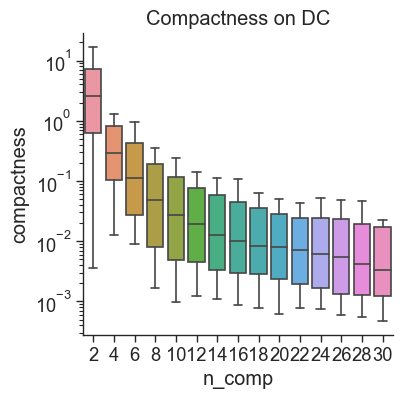

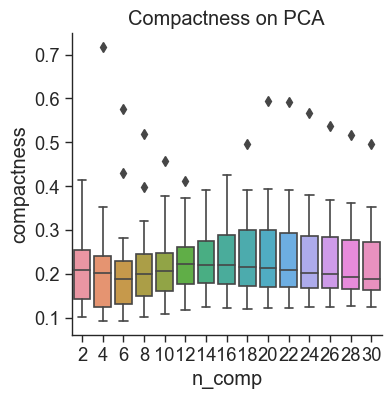

In [263]:

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'DC'], y='compactness', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Compactness on DC')
sns.despine()
plt.show()
plt.close()

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'X_pca'], y='compactness', x = 'n_comp')
#plt.yscale('log')
plt.title('Compactness on PCA')
sns.despine()
plt.show()
plt.close()

### Compute *separation* for a range of latent space components 

In [264]:
importlib.reload(mc_QC)
QC_separation = pd.DataFrame()

#Separation

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    sep_PCA_i = mc_QC.separation(ad, 'X_pca', n_comp = n_comp_i, DO_DC = False, MC_label = MC_label)
    sep_DC_i = mc_QC.separation(ad, 'X_pca', n_comp = n_comp_i, DO_DC = True, MC_label = MC_label)
    
    
    QC_separation = pd.concat([QC_separation, sep_PCA_i, sep_DC_i], ignore_index=True)
QC_separation

2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,separation,low_dim_embedding,n_comp,membership
0,0.323048,X_pca,2,1
1,0.383991,X_pca,2,2
2,0.645818,X_pca,2,3
3,0.172515,X_pca,2,4
4,1.154077,X_pca,2,5
...,...,...,...,...
775,0.098262,DC,30,22
776,0.600546,DC,30,23
777,0.159518,DC,30,24
778,0.238416,DC,30,25


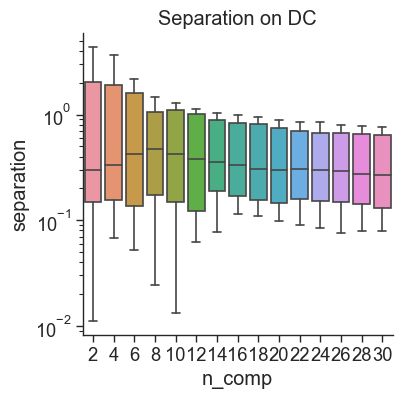

In [265]:
plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'DC'], y='separation', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Separation on DC')
sns.despine()
plt.show()
plt.close()

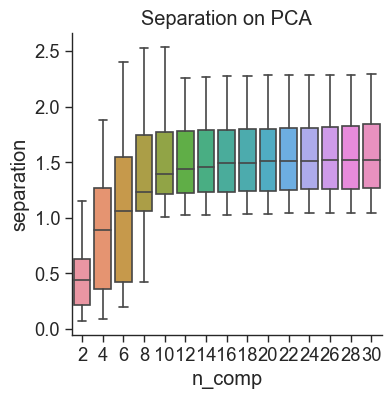

In [266]:
plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'X_pca'], y='separation', x = 'n_comp', showfliers = False)
#plt.yscale('log')
plt.title('Separation on PCA')
sns.despine()
plt.show()
plt.close()

In [267]:
QC = QC_compactness.merge(QC_separation, on=['low_dim_embedding', 'n_comp', 'membership'])

QC = SEACell_ad.obs.iloc[:,:7].merge(QC, on = 'membership')

QC

,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,compactness,low_dim_embedding,n_comp,separation
0,20,100,101,Kmeans,101,CD8 T cells,0.954545,0.203857,X_pca,2,0.749206
1,20,100,101,Kmeans,101,CD8 T cells,0.954545,4.905233,DC,2,2.384030
2,20,100,101,Kmeans,101,CD8 T cells,0.954545,0.216232,X_pca,4,1.037801
3,20,100,101,Kmeans,101,CD8 T cells,0.954545,3.643480,DC,4,3.647640
4,20,100,101,Kmeans,101,CD8 T cells,0.954545,0.224357,X_pca,6,1.074345
...,...,...,...,...,...,...,...,...,...,...,...
775,12,100,101,Kmeans,12,CD14+ Monocytes,0.960000,0.015186,DC,26,6.841055
776,12,100,101,Kmeans,12,CD14+ Monocytes,0.960000,0.517532,X_pca,28,12.900681
777,12,100,101,Kmeans,12,CD14+ Monocytes,0.960000,0.017864,DC,28,7.028685
778,12,100,101,Kmeans,12,CD14+ Monocytes,0.960000,0.496490,X_pca,30,12.901519


Text(0.3, 0, 'r = 0.2002')

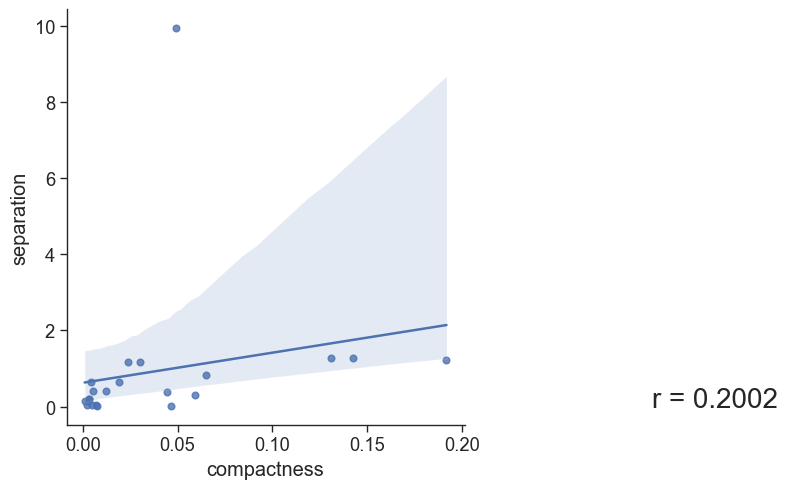

In [268]:
import scipy
df = QC[(QC['low_dim_embedding'] == 'DC') & (QC['n_comp'] == 10)]
#df['size'] = mc_size.cell_line
df = df[(df['separation']<100) & (df['compactness']<.2)]
r = df.compactness.corr(df.separation)

#sns.scatterplot(x="compactness", y="separation", data=df)
sns.lmplot(x="compactness", y="separation", data=df)

#add correlation coefficient to plot
plt.text(.3,0, 'r = ' + str(round(r, 4)), fontsize=20)


In [269]:
importlib.reload(mc_QC)
ad.obs['membership_str'] = [str(i-1) for i in ad.obs.membership]
mc_INV = mc_QC.mc_inner_normalized_var(ad, MC_label='membership_str')
mc_INV.index = [int(i) for i in mc_INV.index]

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/pandas/core/arraylike.py:490: RuntimeWarning: divide by zero encountered in reciprocal
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [270]:
mc_INV.index


Int64Index([ 0,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23,
            24, 25,  3,  4,  5,  6,  7,  8,  9],
           dtype='int64')

In [271]:
SEACell_ad.obs = SEACell_ad.obs.iloc[:,:11]

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [272]:
SEACell_ad.obs

,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC
0,20,100,101,Kmeans,101,CD8 T cells,0.954545,0.247014,0.191804,1.243079,1.221194
1,23,100,101,Kmeans,141,CD4 T cells,0.932203,0.184963,0.460954,1.263424,0.921682
2,2,100,101,Kmeans,177,CD14+ Monocytes,1.000000,0.146080,0.059344,1.123368,0.313714
3,17,100,101,Kmeans,101,B cells,0.989362,0.225833,0.142595,2.048092,1.280357
4,13,100,101,Kmeans,46,Dendritic cells,0.531915,0.318305,0.005605,1.407537,0.419826
5,10,100,101,Kmeans,158,NK cells,0.957447,0.110991,0.002081,1.010509,0.039028
6,16,100,101,Kmeans,24,CD14+ Monocytes,0.913978,0.377290,0.420256,2.539777,0.826368
7,22,100,101,Kmeans,134,CD4 T cells,0.983957,0.164670,0.046350,1.248589,0.013391
8,8,100,101,Kmeans,187,FCGR3A+ Monocytes,0.889706,0.129208,0.006956,1.199680,0.039028
9,14,100,101,Kmeans,207,CD4 T cells,0.974684,0.126688,0.004756,1.010509,0.040099


In [273]:
mc_INV_val = mc_INV.quantile([0.05, 0.5, 0.95], axis=1, numeric_only=True)
mc_INV_val = pd.DataFrame(mc_INV_val.transpose()).set_axis(['INV_5', 'INV_50','INV_95'], axis=1, inplace=False)
#mc_INV_val = pd.DataFrame.from_dict(mc_INV_val, orient='index', columns=['INV_95'])
SEACell_ad.obs = SEACell_ad.obs.join(mc_INV_val)

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [274]:
SEACell_ad.obs

,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC,INV_5,INV_50,INV_95
0,20,100,101,Kmeans,101,CD8 T cells,0.954545,0.247014,0.191804,1.243079,1.221194,0.000038,0.000614,0.061117
1,23,100,101,Kmeans,141,CD4 T cells,0.932203,0.184963,0.460954,1.263424,0.921682,0.000004,0.000225,0.032707
2,2,100,101,Kmeans,177,CD14+ Monocytes,1.000000,0.146080,0.059344,1.123368,0.313714,0.000140,0.001393,0.155853
3,17,100,101,Kmeans,101,B cells,0.989362,0.225833,0.142595,2.048092,1.280357,0.000045,0.000596,0.050198
4,13,100,101,Kmeans,46,Dendritic cells,0.531915,0.318305,0.005605,1.407537,0.419826,0.000012,0.000341,0.044009
5,10,100,101,Kmeans,158,NK cells,0.957447,0.110991,0.002081,1.010509,0.039028,0.000129,0.001380,0.101755
6,16,100,101,Kmeans,24,CD14+ Monocytes,0.913978,0.377290,0.420256,2.539777,0.826368,0.000010,0.000302,0.053153
7,22,100,101,Kmeans,134,CD4 T cells,0.983957,0.164670,0.046350,1.248589,0.013391,0.000006,0.000236,0.027861
8,8,100,101,Kmeans,187,FCGR3A+ Monocytes,0.889706,0.129208,0.006956,1.199680,0.039028,0.000003,0.000188,0.043755
9,14,100,101,Kmeans,207,CD4 T cells,0.974684,0.126688,0.004756,1.010509,0.040099,0.000008,0.000252,0.029985


In [275]:
SEACell_ad.uns['QC_separation_compactness_PC_range'] = QC

## Saving data for the downstream analysis

In [276]:
meth_name = 'kmeans'
SEACell_ad.write(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}.h5ad'))
SEACell_ad.obs.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_metacell_obs.csv'))
ad.obs.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_singlecell_obs.csv'))
QC.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_QC.csv'))


In [277]:
gamma

100

In [13]:
pd.DataFrame(ad.obsm['X_pca'])

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,5.556233,0.257714,-0.186810,2.800131,-0.033783,-0.189702,0.310228,-1.323691,2.691945,0.125928,...,-0.266174,1.024464,-0.709844,-0.052780,-0.686898,-1.419867,-2.865078,0.027601,2.671032,-0.297620
1,7.209530,7.481985,0.162706,-8.018575,3.012900,0.322293,2.270888,-0.605055,-0.905611,1.225260,...,0.158161,0.819037,0.578912,-1.169742,0.955408,0.068133,-0.883082,2.930932,0.354197,-1.081801
2,2.694438,-1.583658,-0.663126,2.205649,-1.686360,-1.965395,-1.894999,-1.522103,1.914985,-0.481202,...,-1.054254,0.805932,1.543282,1.504834,-0.831818,-0.236549,1.883515,1.084782,0.381470,0.064662
3,-10.143295,-1.368530,1.209812,-0.700096,-2.872336,0.230617,1.278005,0.487900,-0.447965,-0.328465,...,1.297246,0.611073,-0.007878,-0.648735,0.543566,3.156763,1.691134,-0.301377,-0.225427,0.962879
4,-1.112816,-8.152788,1.332405,-4.252473,2.036407,5.597797,-0.110658,-0.102257,0.014520,0.581409,...,1.191032,1.042533,1.734694,-0.142114,0.586381,0.636326,-1.451625,1.809683,-0.087072,-0.737833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633,-9.601189,-0.180182,1.452586,-0.237521,5.016192,-2.838224,1.033840,3.258723,-1.324030,-1.137737,...,2.892193,-0.090319,0.449330,-0.876949,0.145743,3.023428,0.584328,-0.985668,-0.653246,-0.255705
2634,2.847881,3.722198,-0.217027,-4.692667,-0.201969,0.136037,-0.089929,-1.125029,1.302543,4.058832,...,-3.821146,-1.932060,-0.372657,0.183218,2.293771,-1.135456,-0.613224,-0.121579,0.416659,1.059371
2635,0.785397,6.718592,1.598848,-4.170253,-0.792333,0.984998,0.459763,0.970320,-0.269792,-0.337530,...,0.551644,-0.230965,-2.634472,-0.375540,-0.895456,-1.512018,0.383293,-1.181886,0.950911,-0.297822
2636,-0.281272,5.921856,1.162878,-7.346007,-0.433892,-0.143446,0.610780,-1.365791,-0.070926,0.406122,...,-0.806054,-1.840753,0.500691,-1.836806,2.175339,-1.710460,-1.163464,-0.938382,0.343397,-1.006987


KeyError: 'X_pca'

In [15]:
ad.var_names[ad.var['highly_variable']].to_list()

['CPSF3L',
 'ATAD3C',
 'TNFRSF25',
 'CTNNBIP1',
 'UBIAD1',
 'TNFRSF1B',
 'DDI2',
 'SDHB',
 'CAMK2N1',
 'CDA',
 'C1QB',
 'ZNF436',
 'PITHD1',
 'HMGCL',
 'LDLRAP1',
 'PDIK1L',
 'ZNF593',
 'PHACTR4',
 'TAF12',
 'YTHDF2',
 'SPOCD1',
 'HDAC1',
 'SMIM12',
 'AGO4',
 'TRAPPC3',
 'EVA1B',
 'RRAGC',
 'PPIE',
 'TRIT1',
 'SMAP2',
 'DMAP1',
 'ERI3',
 'EFCAB14',
 'PDZK1IP1',
 'TAL1',
 'HSPB11',
 'SSBP3',
 'PGM1',
 'LRRIQ3',
 'ACADM',
 'IFI44',
 'SH3GLB1',
 'GTF2B',
 'GBP1',
 'GBP4',
 'TMED5',
 'RP11-421L21.3',
 'SARS',
 'DRAM2',
 'DENND2D',
 'CHI3L2',
 'FAM212B-AS1',
 'RP11-88H9.2',
 'ST7L',
 'RP5-1073O3.7',
 'WARS2',
 'CD160',
 'BOLA1',
 'MLLT11',
 'C2CD4D',
 'S100A9',
 'S100A12',
 'S100A8',
 'SNAPIN',
 'CRTC2',
 'UBE2Q1',
 'CKS1B',
 'PMF1',
 'GPATCH4',
 'HDGF',
 'AIM2',
 'FCER1A',
 'DCAF8',
 'PEX19',
 'PFDN2',
 'DEDD',
 'FCGR2A',
 'FCRLA',
 'TMCO1',
 'MPC2',
 'SELL',
 'RP1-102G20.5',
 'KIAA0040',
 'QSOX1',
 'DHX9',
 'RGS18',
 'CSRP1',
 'PTPN7',
 'SOX13',
 'IL24',
 'CR1',
 'RP1-28O10.1',
 'G0S2',
 

In [9]:
ad

AnnData object with n_obs × n_vars = 2638 × 32738
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'log1p', 'hvg', 'umap'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'